In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import folium
import bokeh
import seaborn as sns

In [3]:
pip install pandas openpyxl

Note: you may need to restart the kernel to use updated packages.


In [ ]:
file_path = "./M1045_MonthlyCrimeDashboard_TNOCrimeData.xlsx"
xls = pd.ExcelFile(file_path)

print(xls.sheet_names)

sheet_name = xls.sheet_names[0]
df = pd.read_excel(xls, engine="openpyxl")

csv_file_path = "crime_data.csv"
df.to_csv(csv_file_path, index=False)

print(f"CSV file saved as: {csv_file_path}")

KeyboardInterrupt: 

In [12]:
#Convert Month_Year to datetime format
file_path = "./crime_data_filtered.csv"
crime_df = pd.read_csv(file_path)

In [26]:
#Data cleaning
cleaned_df = crime_df.dropna(subset = ["Area name"])
cleaned_df = crime_df[crime_df["Measure"]== "Offences"]
cleande_df = crime_df[crime_df["Offence Group"] != "Other / NK"]
cleaned_df = crime_df[crime_df["Area name"] != "Other / NK"]
# cleaned_df["Month_Year"] = pd.to_datetime(crime_df["Month_Year"])

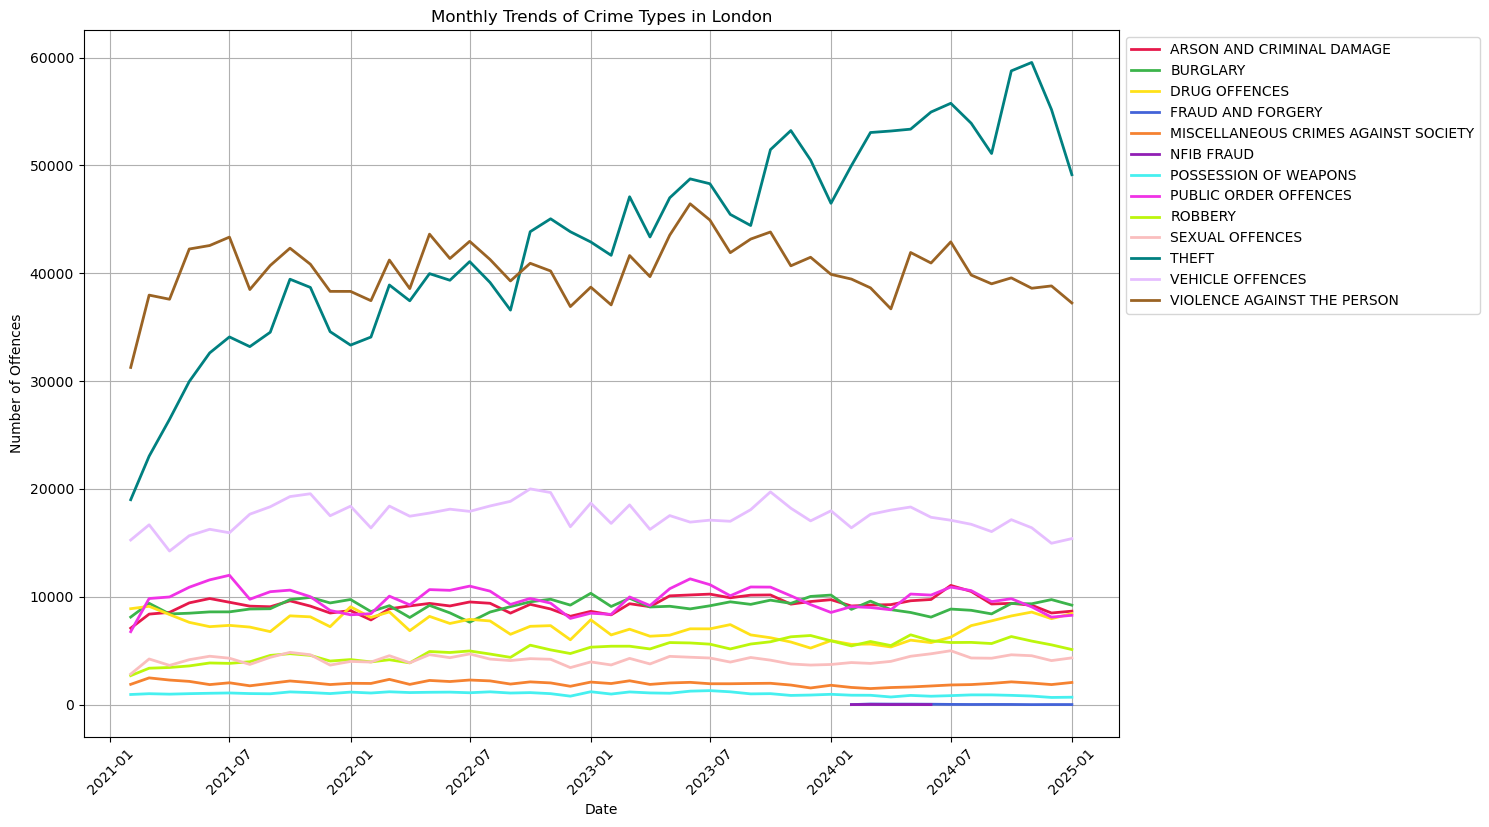

In [17]:
#Visualization 1 (Multi-line Time Series Chart - Q1)
crime_offences = crime_df[crime_df["Measure"] == "Offences"]

# Grouping by Month_Year and Offence Group to observe trends
crime_trend_grouped = crime_offences.groupby(["Month_Year", "Offence Group"])["Count"].sum().reset_index()

# Convert Month_Year to datetime for sorting and plotting
crime_trend_grouped["Month_Year"] = pd.to_datetime(crime_trend_grouped["Month_Year"])

# Pivot the data to have offence groups as columns
crime_trend_pivot = crime_trend_grouped.pivot(index="Month_Year", columns="Offence Group", values="Count")

#Defines a color map: custom Hex codes
user_colors = [
    "#E6194B", "#3CB44B", "#FFE119", "#4363D8",
    "#F58231", "#911EB4", "#46F0F0", "#F032E6",
    "#BCF60C", "#FABEBE", "#008080", "#E6BEFF",
    "#9A6324"
]

# Plot
plt.figure(figsize=(15, 8))
for i, column in enumerate(crime_trend_pivot.columns):
    colors = user_colors[i % len(user_colors)]
    plt.plot(crime_trend_pivot.index, crime_trend_pivot[column], label=column, color=colors, linewidth=2)

plt.title("Monthly Trends of Crime Types in London")
plt.xlabel("Date")
plt.ylabel("Number of Offences")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)

plt.savefig("Viz1.jpg", dpi=300)
plt.show()

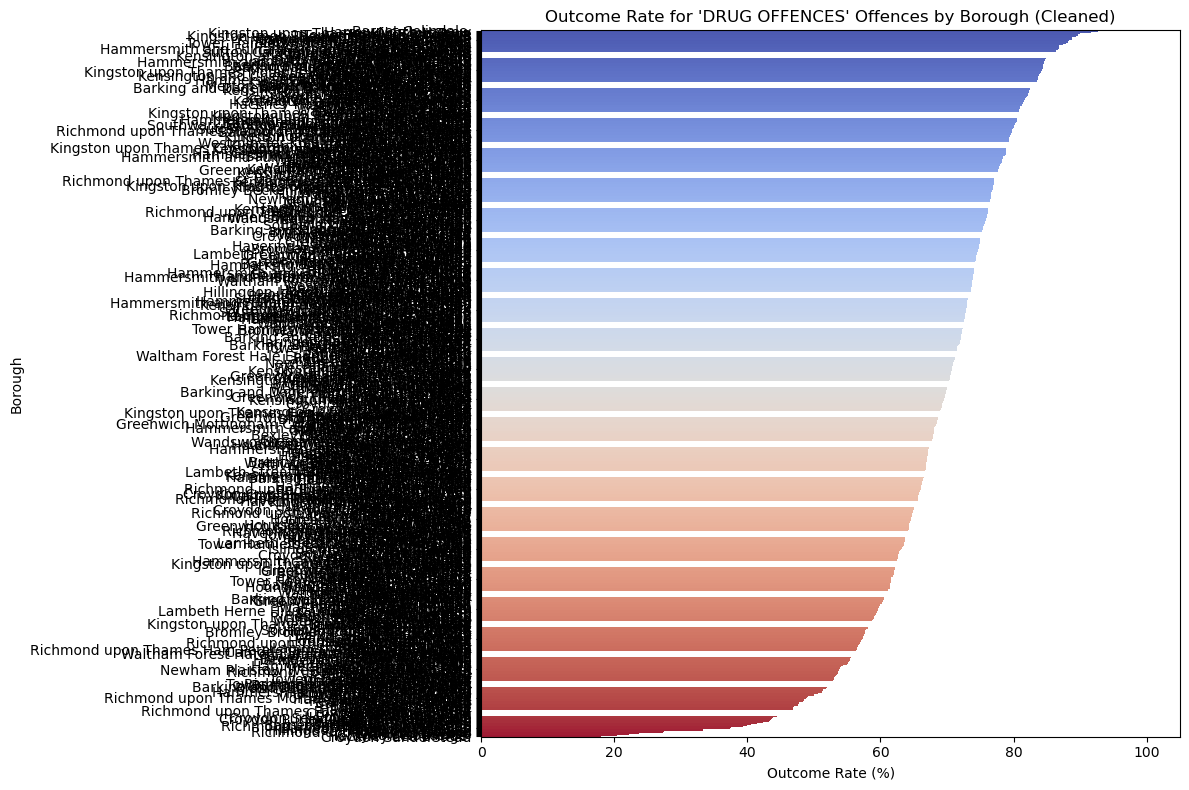

In [46]:
# Reload the dataset
file_path = "./crime_data.csv"
crime_df = pd.read_csv(file_path)

#Visualization 2 (Heatmap of Positive Outcome Rates - Q2)

# Select the offence type for analysis (e.g., "THEFT")
selected_offence = "DRUG OFFENCES"

# Filter data for the selected offence type for Offences and Positive Outcomes
offences_sel_boro = crime_df[(crime_df["Measure"] == "Offences") & (crime_df["Offence Group"] == selected_offence)]
outcomes_sel_boro = crime_df[(crime_df["Measure"] == "Positive Outcomes") & (crime_df["Offence Group"] == selected_offence)]

# Group by Borough_SNT instead of Area name
offences_grouped_boro = offences_sel_boro.groupby("Borough_SNT")["Count"].sum().reset_index()
outcomes_grouped_boro = outcomes_sel_boro.groupby("Borough_SNT")["Count"].sum().reset_index()

# Merge and calculate outcome rate
merged_boro = pd.merge(offences_grouped_boro, outcomes_grouped_boro, on="Borough_SNT", suffixes=('_offences', '_outcomes'))
merged_boro["Outcome Rate (%)"] = merged_boro["Count_outcomes"] / merged_boro["Count_offences"] * 100

# Sort for clarity
merged_boro_sorted = merged_boro.sort_values(by="Outcome Rate (%)", ascending=False)

# Plot the cleaned version
plt.figure(figsize=(12, 8))
sns.barplot(data=merged_boro_sorted, x="Outcome Rate (%)", y="Borough_SNT", hue="Borough_SNT", palette="coolwarm", legend=False)
plt.title(f"Outcome Rate for '{selected_offence}' Offences by Borough (Cleaned)")
plt.xlabel("Outcome Rate (%)")
plt.ylabel("Borough")
plt.tight_layout()
plt.show()


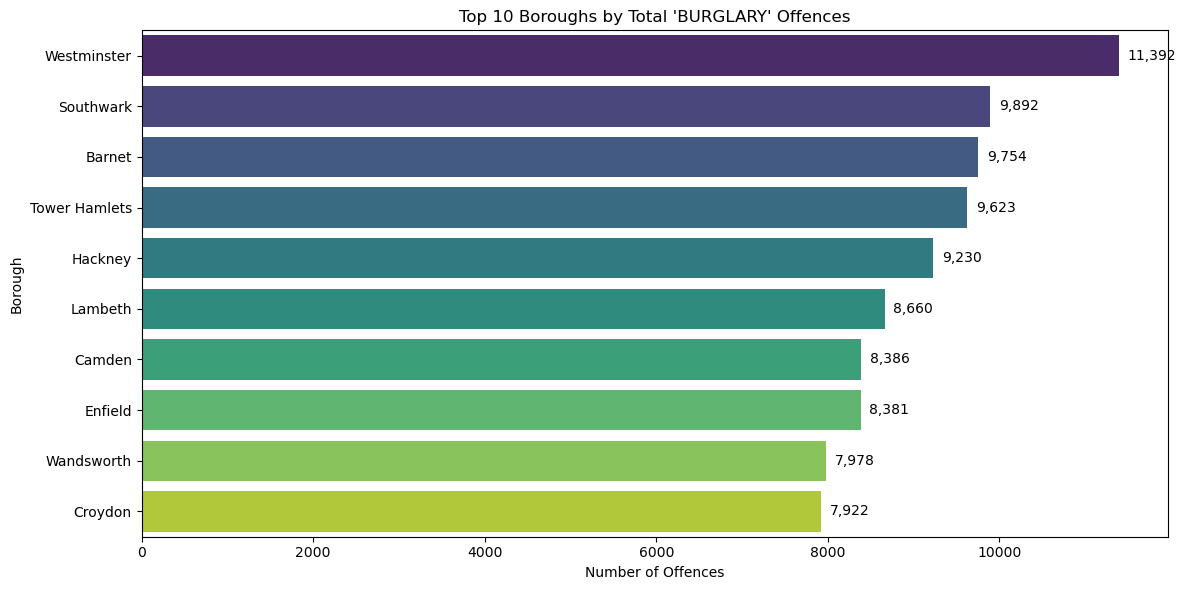

In [18]:
#Visualization 2: Horizontal Bar Chart with annotations
selected_offence = "BURGLARY"
q3_df = crime_df[(crime_df["Measure"] == "Offences") & (crime_df["Offence Group"] == selected_offence) & (crime_df["Area name"] != "Other / NK")]
q3_grouped = q3_df.groupby("Area name")["Count"].sum().reset_index()
top_boroughs_q3 = q3_grouped.sort_values(by="Count", ascending=False).head(10)

# Plot with total values at end of bars
plt.figure(figsize=(12, 6))
barplot = sns.barplot(data=top_boroughs_q3, x="Count", y="Area name", hue="Area name", palette="viridis", legend=False)

# Add annotations
for i, value in enumerate(top_boroughs_q3["Count"]):
    plt.text(value + 100, i, f"{value:,}", va='center', fontsize=10)

plt.title(f"Top 10 Boroughs by Total '{selected_offence}' Offences")
plt.xlabel("Number of Offences")
plt.ylabel("Borough")
plt.tight_layout()

plt.savefig("Viz2.jpg", dpi=300, bbox_inches="tight")
plt.show()

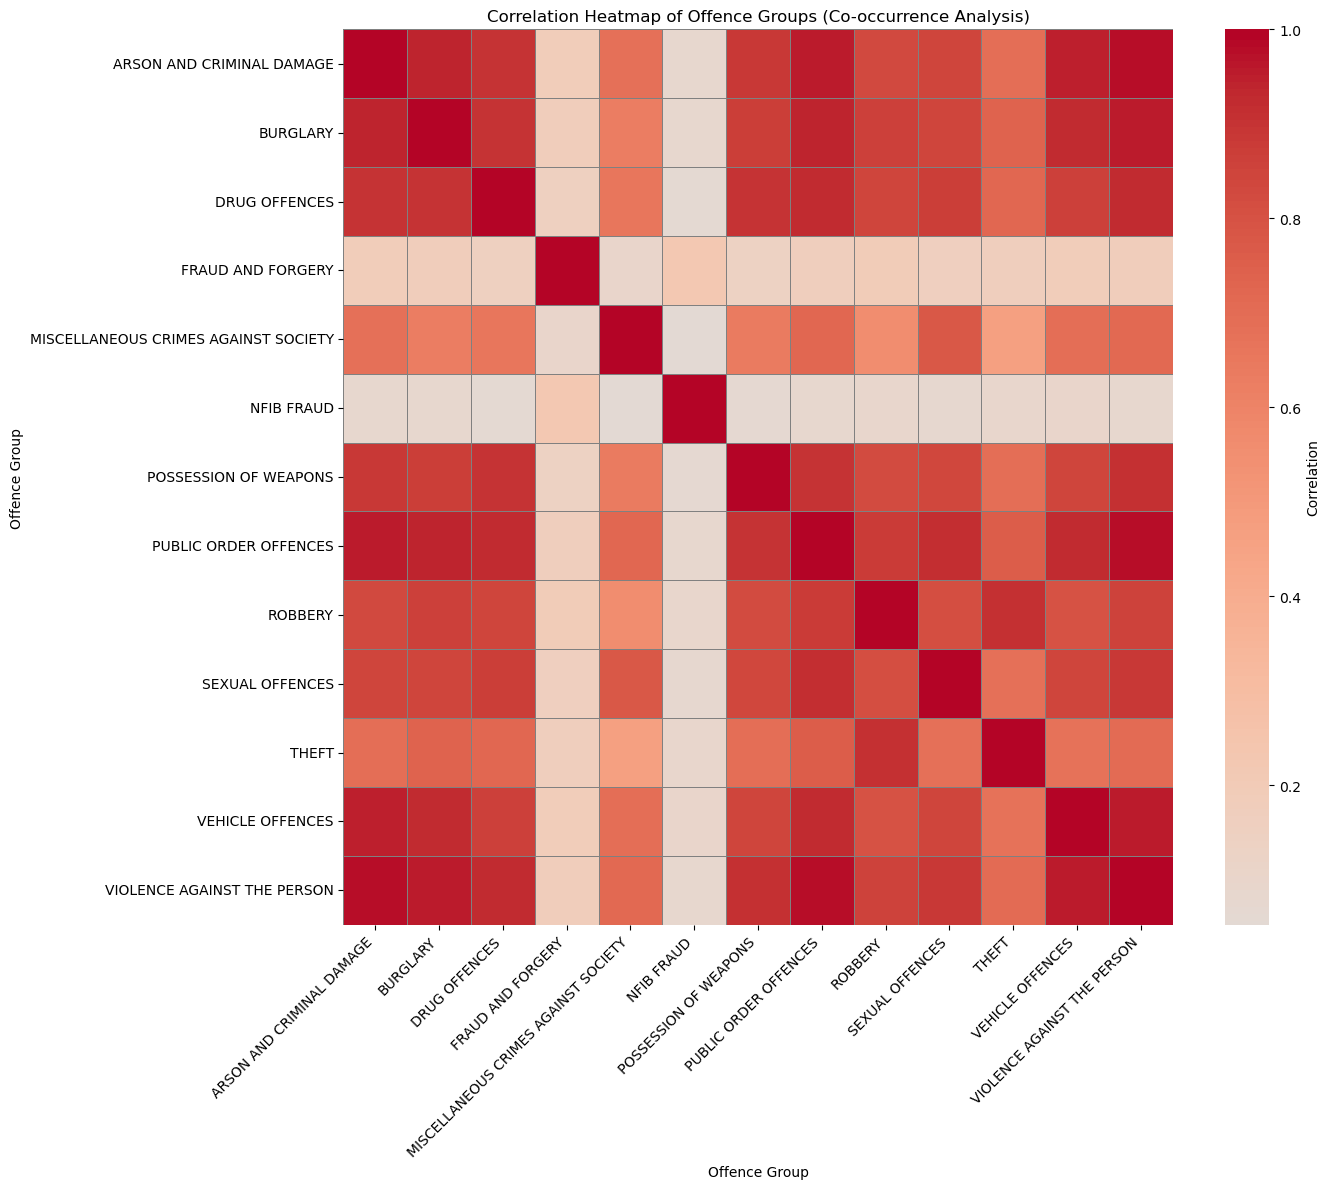

In [19]:
#Filter for "Offences" and keep relevant columns
q5_df = crime_df[crime_df["Measure"] == "Offences"]
q5_df = q5_df[["Month_Year", "Area name", "Offence Group", "Count"]]

#Group by Month, Borough, and Offence Group
q5_grouped = q5_df.groupby(["Month_Year", "Area name", "Offence Group"])["Count"].sum().reset_index()

#Pivot to create a matrix: rows = (Month_Year, Borough), columns = Offence Groups
q5_pivot = q5_grouped.pivot_table(index=["Month_Year", "Area name"], columns="Offence Group", values="Count", fill_value=0)

#Compute correlation between offence types
correlation_matrix = q5_pivot.corr()

#Plot correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, cmap="coolwarm", center=0, annot=False, linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Correlation'})
plt.title("Correlation Heatmap of Offence Groups (Co-occurrence Analysis)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.savefig("Viz3.jpg", dpi=300)
plt.show()

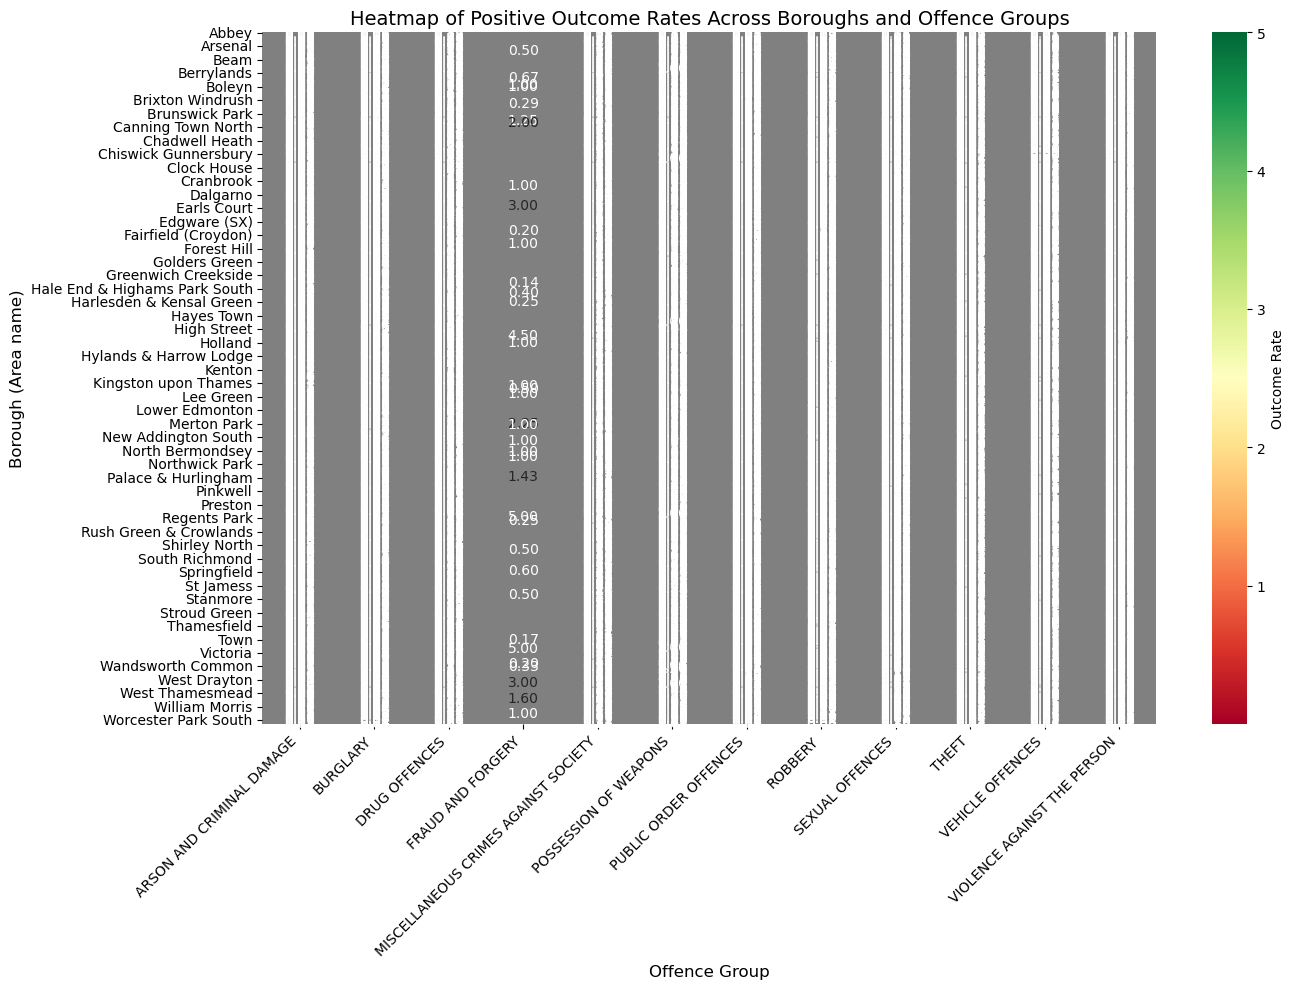

In [108]:
# Replot Visualization 2 (Q2) with improved visibility

# Step 1: Filter for relevant measures
offences_df = crime_df[crime_df["Measure"] == "Offences"]
outcomes_df = crime_df[crime_df["Measure"] == "Positive Outcomes"]

# Step 2: Group and aggregate both sets
offences_grouped = offences_df.groupby(["Area name", "Offence Group"])["Count"].sum().reset_index()
outcomes_grouped = outcomes_df.groupby(["Area name", "Offence Group"])["Count"].sum().reset_index()

# Step 3: Merge and calculate outcome rate
merged_df = pd.merge(offences_grouped, outcomes_grouped, on=["Area name", "Offence Group"], suffixes=('_offences', '_outcomes'))
merged_df["Outcome Rate"] = merged_df["Count_outcomes"] / merged_df["Count_offences"]

# Step 4: Pivot for heatmap format
heatmap_data = merged_df.pivot(index="Area name", columns="Offence Group", values="Outcome Rate")

# Step 5: Plot the improved heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Outcome Rate'}
)
plt.title("Heatmap of Positive Outcome Rates Across Boroughs and Offence Groups", fontsize=14)
plt.xlabel("Offence Group", fontsize=12)
plt.ylabel("Borough (Area name)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [22]:
df = pd.read_csv("./crime_data_filtered.csv")
df.columns.tolist()

['Month_Year', 'Area name', 'Offence Group', 'Measure', 'Count']

In [30]:
cleaned_df = crime_df.dropna(subset = ["Area name"])
cleaned_df = crime_df[crime_df["Measure"]== "Offences"]
cleande_df = crime_df[crime_df["Offence Group"] != "Other / NK"]
cleaned_df = crime_df[crime_df["Area name"] != "Other / NK"]
# cleaned_df["Month_Year"] = pd.to_datetime(crime_df["Month_Year"])
optimized_file = "./crime_data_filtered_cleaned.csv"
cleaned_df.to_csv(optimized_file, index=False)

optimized_file

'./crime_data_filtered_cleaned.csv'